In [1]:
import pandas as pd
import json
import json
from tqdm import tqdm
import pandas as pd
import sys
sys.path.append("../src")
import prompt_utils
import os
import random
from typing import List
import llm_utils

# vicuna 
# with rules classification only (beta 0.5: 0.76, beta 0.25: 0.86) (0.7-0.8s per prompt)
vicuna_base_path = "../data/vicuna_4bit/"
vicuna_with_rules_classification_only_name = "generic_prompt_with_rules_only_classification"
vicuna_with_rules_classification_only_func = prompt_utils.get_vicuna_prompt_with_rules_only_classification

# OA LLAMA
# Classification Only V03 (bta 0.5: 0.81, beta 0.25: 0.83)
# With Rules Classification only (beta 0.5: 0.8, beta 0.25: 0.89)
# With 3 Random Examples Classification only (beta 0.5: 0.78, beta 0.25: 0.88)
oa_base_path = "../data/openassistant_llama_30b_4bit/"
oa_classification_only_v03_name = "generic_prompt_without_context_only_classification_v03"
oa_classification_only_v03_func = prompt_utils.get_openassistant_llama_30b_4bit_without_context_only_classification_v03 #
oa_with_rules_classification_only_name = "generic_prompt_with_rules_only_classification"
oa_with_rules_classification_only_func = prompt_utils.get_openassistant_llama_30b_4bit_with_rules_only_classification
oa_with_3_random_examples_classification_only_name = "generic_prompt_few_shot_prompt_only_classification_3_random_example"
oa_with_3_random_examples_classification_only_func = prompt_utils.get_openassistant_llama_30b_4bit_few_shot_prompt_only_classification_n_random_example

# Text Davinci
# Elaboration First V04 (beta 0.5: 0.87, beta 0.25: 0.93)
davinci_base_path = "../data/openai_text_davinci_003/"
davinci_elaboration_first_v04_name = "generic_prompt_without_context_elaboration_first_v04"
davinci_elaboration_first_v04_func = prompt_utils.get_openai_prompt_without_context_elaboration_first_v04

# Define a list of filenames to load
labeled_data_filename = "../data/labeled_data/generic_test_0.json"

dfs = []
with open(labeled_data_filename) as f:
    data = json.load(f)
df = pd.DataFrame(data["train"])
dfs.append(df)
df = pd.DataFrame(data["test"])
dfs.append(df)
df = pd.DataFrame(data["valid"])
dfs.append(df)
df_all = pd.concat(dfs)
ALL_LABELS = prompt_utils.ALL_LABELS[:-1]
LOW_F1_LABELS = prompt_utils.LOW_F1_LABELS

In [2]:
def initialize_eng_dataframe():
    unlabeled_dataset = prompt_utils.generate_unlabeled_dataset()
    return unlabeled_dataset.loc[unlabeled_dataset.tweet_language == "en"].sample(frac=1, random_state = 42).reset_index()

def find_start_index(df: pd.DataFrame, new_column_names: List[str]) -> int:
    # Find first row where all weak labels are NaN
    try:
        start_index = df[new_column_names].isna().all(axis=1).idxmax()
        # If no NaN found in any of new_column_names, start from beginning
        if pd.isna(start_index):
            start_index = 0
        return start_index
    except:
        return 0
    
output_folder = f"{vicuna_base_path}/{vicuna_with_rules_classification_only_name}"
model_name = "low_f1_labels_weak_labeling"
prompt_func = vicuna_with_rules_classification_only_func
idx_of_rules_of_low_f1_labels = [1, 2, 4, 9, 12, 13]

eng_tweets_vicuna_rules_classification_only = pd.read_csv(f"{output_folder}/{model_name}.csv")

output_folder = f"{oa_base_path}/{oa_classification_only_v03_name}"
eng_tweets_oa_classification_only_v03 = pd.read_csv(f"{output_folder}/{model_name}.csv")

output_folder = f"{oa_base_path}/{oa_with_rules_classification_only_name}"
eng_tweets_oa_rules_classification_only = pd.read_csv(f"{output_folder}/{model_name}.csv")

output_folder = f"{oa_base_path}/{oa_with_3_random_examples_classification_only_name}"
eng_tweets_a_3_random_examples_classification_only = pd.read_csv(f"{output_folder}/{model_name}.csv")

output_folder = f"{davinci_base_path}/{davinci_elaboration_first_v04_name}"
eng_tweets_davinci_elaboration_first_v04 = pd.read_csv(f"{output_folder}/{model_name}.csv")

/tmp/ipykernel_25205/101878510.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,22,23,28,29,30,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  eng_tweets_vicuna_rules_classification_only = pd.read_csv(f"{output_folder}/{model_name}.csv")
/tmp/ipykernel_25205/101878510.py:24: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,22,23,28,29,30,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  eng_tweets_oa_classification_only_v03 = pd.read_csv(f"{output_folder}/{model_name}.csv")
/tmp/ipykernel_25205/101878510.py:27: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,22,23,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  eng_tweets_oa_rules_classification_only = pd.read_csv(f"{output_folder}/{model_name}.csv")
/tmp/ipykernel_25205/101878510.py:30: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,1

In [3]:
eng_tweets_vicuna_rules_classification_only = eng_tweets_vicuna_rules_classification_only.iloc[0:2000]
eng_tweets_oa_classification_only_v03 = eng_tweets_oa_classification_only_v03.iloc[0:2000]
eng_tweets_oa_rules_classification_only = eng_tweets_oa_rules_classification_only.iloc[0:2000]
eng_tweets_a_3_random_examples_classification_only = eng_tweets_a_3_random_examples_classification_only.iloc[0:2000]
eng_tweets_davinci_elaboration_first_v04 = eng_tweets_davinci_elaboration_first_v04.iloc[0:2000]

In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re

# Your function to perform NLP analysis
def nlp_analysis(df, column_name):

    # Number of tweets
    num_tweets = len(df)

    # Average word count of tweets
    avg_word_count = df[column_name].apply(lambda x: len(x.split())).mean()

    # Most common words (top 10)
    vectorizer = CountVectorizer(stop_words='english')
    all_words = ' '.join([text for text in df[column_name]])
    word_count = vectorizer.fit_transform([all_words])
    words_freq = sorted(list(zip(vectorizer.get_feature_names_out(), word_count.sum(axis=0).getA1())), key=lambda x: x[1], reverse=True)[:10]
    
    # Most common hashtags (top 10)
    df['hashtags'] = df[column_name].apply(lambda x: re.findall(r'\#\w+', x))
    all_hashtags = sum(df['hashtags'].tolist(), [])
    hashtags_freq = pd.Series(all_hashtags).value_counts()[:10]

    # Sentiment analysis (average polarity and subjectivity)
    df['polarity'] = df[column_name].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df[column_name].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    avg_polarity = df['polarity'].mean()
    avg_subjectivity = df['subjectivity'].mean()

    print(f"Number of tweets: {num_tweets}")
    print(f"Average word count: {avg_word_count}")
    print(f"Most common words: {words_freq}")
    print(f"Most common hashtags: {hashtags_freq}")
    print(f"Average polarity: {avg_polarity}")
    print(f"Average subjectivity: {avg_subjectivity}")
    print("\n\n")

# Apply the function to each dataframe
print("Analysis of dataframe with name: ", df_names[0])
nlp_analysis(dataframes[0], 'tweet_text')

Analysis of dataframe with name:  vicuna
Number of tweets: 2000
Average word count: 14.9495
Most common words: [('https', 2455), ('rt', 527), ('trump', 412), ('video', 164), ('breaking', 151), ('just', 101), ('amp', 82), ('obama', 80), ('new', 75), ('president', 75)]
Most common hashtags: #M7UGsChoice         29
#top                 11
#mar                 10
#th                  10
#ThankYouPoliceUg     8
#MAGA                 6
#MondayMotivation     6
#Syria                6
#cic                  5
#vero                 5
dtype: int64
Average polarity: 0.0455934957107418
Average subjectivity: 0.27677289039664044





In [5]:
import numpy as np
import pandas as pd
import llm_utils

# List with the names of your dataframes
dfs = [eng_tweets_vicuna_rules_classification_only, eng_tweets_oa_classification_only_v03, eng_tweets_oa_rules_classification_only, eng_tweets_a_3_random_examples_classification_only, eng_tweets_davinci_elaboration_first_v04]
dfs_extracted = []
extraction_functions = [llm_utils.get_extraction_function("extract_nth_character", 2), llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.get_extraction_function("extract_using_class_token", 1)]
# Names for the tables in the Latex file
df_names = ["vicuna", "oa_v03", "oa_rules", "oa_random_examples", "davinci"]

results = {}

for df, extraction_function in zip(dfs, extraction_functions):
    df = df.fillna(0)
    for label in LOW_F1_LABELS:
        df[f'{label}_pred'] = df[f'{label}_pred'].apply(extraction_function)
    dfs_extracted.append(df)

In [6]:
dfs_extracted[0]

,index,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,...,poll_choices,Conspiracy Theory_pred,Education_pred,Environment_pred,Labor/Employment_pred,Religion_pred,Science/Technology_pred
0,1254904,825252864771567617,z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=,z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=,z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=,Estados Unidos,FOLLOW AND DISCOVER ALL THE LAST MINUTE. TOP U...,...,0.0,0,0,0,0,0,0
1,1082628,816229906983964672,EnJOMZA4bIqKIG7CS5cI7OPKgxg6HAIo4+AwnWjN44=,EnJOMZA4bIqKIG7CS5cI7OPKgxg6HAIo4+AwnWjN44=,EnJOMZA4bIqKIG7CS5cI7OPKgxg6HAIo4+AwnWjN44=,Estados Unidos,All information of america and more.. TOP USA ...,...,0.0,0,0,0,0,0,0
2,1293885,903817338709008386,wwec6zN1bIVqojfFvFx9D3TGpTTqerWyIcvmP0tIDaE=,wwec6zN1bIVqojfFvFx9D3TGpTTqerWyIcvmP0tIDaE=,wwec6zN1bIVqojfFvFx9D3TGpTTqerWyIcvmP0tIDaE=,Estados Unidos,But he made too many enemies Of the people who...,...,0.0,0,0,0,0,0,0
3,187033,1063439406361731073,xJ57jjSHWvX9mAMmhv7fVaVzxe13bBfCZuGZaBNucL0=,xJ57jjSHWvX9mAMmhv7fVaVzxe13bBfCZuGZaBNucL0=,xJ57jjSHWvX9mAMmhv7fVaVzxe13bBfCZuGZaBNucL0=,"Kampala, Uganda",this page for teamshirumatic updates and the a...,...,0.0,0,0,0,0,0,0
4,281944,1186641059843063808,830195087078518785,ssebunya shafique,ssebunyashaf,Uganda,economics politics music and sports\n@arsenal ...,...,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,104856,644873385747578880,4IESrF58WF9LX1a3RySuP3WebiusoHnD+ZnAr1wmWd0=,4IESrF58WF9LX1a3RySuP3WebiusoHnD+ZnAr1wmWd0=,4IESrF58WF9LX1a3RySuP3WebiusoHnD+ZnAr1wmWd0=,Uganda,Supporting the campaign & re-election of @Kagu...,...,0.0,0,0,0,0,0,0
1996,836894,873538330679549952,zjM1VynckXRrGwh4gmb384xY3JQpuVwZE7EqEbpbQ7c=,zjM1VynckXRrGwh4gmb384xY3JQpuVwZE7EqEbpbQ7c=,zjM1VynckXRrGwh4gmb384xY3JQpuVwZE7EqEbpbQ7c=,Estados Unidos,We take the best information fast and timely p...,...,0.0,0,0,0,0,0,0
1997,641578,826016295174836226,zYH8Owk82nvA7h1yflkRduYaxZUIFlvrBnJjoMvH6cI=,zYH8Owk82nvA7h1yflkRduYaxZUIFlvrBnJjoMvH6cI=,zYH8Owk82nvA7h1yflkRduYaxZUIFlvrBnJjoMvH6cI=,0,"If you want Twee that do not bore you, then fo...",...,0.0,0,0,0,0,0,0
1998,310833,1313004045607596032,ED5jpwAgkc9RVjxuRSVi8Z8glPhTdrHU6Hnkct8S4OQ=,ED5jpwAgkc9RVjxuRSVi8Z8glPhTdrHU6Hnkct8S4OQ=,ED5jpwAgkc9RVjxuRSVi8Z8glPhTdrHU6Hnkct8S4OQ=,0,I am a child of God.,...,0.0,0,0,0,0,0,0


In [24]:

df_names = ["vicuna_with_rules_classification_only_name", "oa_classification_only_v03_name", "oa_with_rules_classification_only_name", "oa_with_3_random_examples_classification_only_name", "davinci_elaboration_first_v04_name"]
for df, df_name in zip(dfs, df_names):

    is_string = isinstance(df['Conspiracy Theory_pred'].iat[0], str)

    for i, row in df.iterrows():
        annotations = []
        for label in LOW_F1_LABELS:
            

            if is_string:
                is_label = row[label+"_pred"].find("1") != -1
            else:
                is_label = row[label+"_pred"] == 1
                
            if is_label:
                annotations.append(label)
        df.at[i, "annotations"] = annotations
    print(df)
    df.to_csv(f"../data/weak_labeled_data/{df_name}_weak_labels_all.csv", index=False)

        index              tweetid                                        userid                             user_display_name                              user_screen_name user_reported_location                           user_profile_description  ...            Conspiracy Theory_pred                    Education_pred                     Environment_pred            Labor/Employment_pred                     Religion_pred           Science/Technology_pred annotations
0     1254904   825252864771567617  z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=  z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=  z1HuUl+9Gxe6nIzglABuIKq1xjSlhgcvfDt9ldrk7Nc=         Estados Unidos  FOLLOW AND DISCOVER ALL THE LAST MINUTE. TOP U...  ...   0 (Not about Conspiracy Theory)    0\n\nThe tweet is not directly   0 (Not related to environment)\n\n        0 (Not related)\n\nExplan   0 (Not related to religion)\n\n   0 (Not about Science/Technology          []
1     1082628   816229906983964672   EnJOMZA4bIqKIG7CS5cI7OP

In [44]:
from functools import reduce
# Loop through each dataframe
for df, df_name in zip(dfs, df_names):

    # Check the type of the first element in the first relevant column
    is_string = isinstance(df['Conspiracy Theory_pred'].iat[0], str)

    if is_string:
        masks = {name: df[f'{name}_pred'].str.contains('0', na=False) for name in ['Conspiracy Theory', 'Education', 'Environment', 'Labor/Employment', 'Religion', 'Science/Technology']}
    else:
        masks = {name: df[f'{name}_pred'] == 0 for name in ['Conspiracy Theory', 'Education', 'Environment', 'Labor/Employment', 'Religion', 'Science/Technology']}

    results[df_name] = {}

    for name, mask in masks.items():
        if is_string:
            preds = df[df[f'{name}_pred'].str.contains('1', na=False)]
            only_pred = df[df[f'{name}_pred'].str.contains('1', na=False) & reduce(lambda x, y: x & y, [m for n, m in masks.items() if n != name])]
        else:
            preds = df[df[f'{name}_pred'] == 1]
            only_pred = df[(df[f'{name}_pred'] == 1) & reduce(lambda x, y: x & y, [m for n, m in masks.items() if n != name])]

        results[df_name][f'{name} predictions'] = len(preds)
        results[df_name][f'only {name} predicted'] = len(only_pred)



# Create the Latex tables
for df_name, result in results.items():
    # Add the model name as a separate row in the DataFrame
    result_with_name = {"Model": df_name}
    result_with_name.update(result)
    df_result = pd.DataFrame(result_with_name, index=[0])
    # Reorder the columns so that "Model" is the first column
    df_result = df_result[['Model'] + [col for col in df_result.columns if col != 'Model']]
    print(df_result.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 Model &  Conspiracy Theory predictions &  only Conspiracy Theory predicted &  Education predictions &  only Education predicted &  Environment predictions &  only Environment predicted &  Labor/Employment predictions &  only Labor/Employment predicted &  Religion predictions &  only Religion predicted &  Science/Technology predictions &  only Science/Technology predicted \\
\midrule
vicuna &                            105 &                                97 &                     89 &                        32 &                       96 &                          48 &                            68 &                               25 &                    40 &                       31 &                              34 &                                  8 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 Model &  Conspiracy Theory predictions &  only Conspiracy Theory predicted &  Education predictions &  only Education predicted

/tmp/ipykernel_146564/913875501.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_result.to_latex(index=False))
/tmp/ipykernel_146564/913875501.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_result.to_latex(index=False))
/tmp/ipykernel_146564/913875501.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore 

In [19]:
eng_tweets_vicuna_rules_classification_only = pd.read_csv("../data/weak_labeled_data/vicuna_with_rules_classification_only_name_weak_labels_all.csv")
eng_tweets_oa_classification_only_v03 = pd.read_csv("../data/weak_labeled_data/oa_classification_only_v03_name_weak_labels_all.csv")
eng_tweets_oa_rules_classification_only = pd.read_csv("../data/weak_labeled_data/oa_with_rules_classification_only_name_weak_labels_all.csv")
eng_tweets_a_3_random_examples_classification_only = pd.read_csv("../data/weak_labeled_data/oa_with_3_random_examples_classification_only_name_weak_labels_all.csv")
eng_tweets_davinci_elaboration_first_v04 = pd.read_csv("../data/weak_labeled_data/davinci_elaboration_first_v04_name_weak_labels_all.csv")

dataframes = [eng_tweets_vicuna_rules_classification_only, eng_tweets_oa_classification_only_v03, eng_tweets_oa_rules_classification_only, eng_tweets_a_3_random_examples_classification_only, eng_tweets_davinci_elaboration_first_v04]
df_names = ["vicuna", "oa_v03", "oa_rules", "oa_random_examples", "davinci"]


Most common words and phrases in tweet_text:
[('rt', 527), ('trump', 368), ('video', 164), ('breaking', 150), ('obama', 76), ('new', 75), ('u', 73), ('people', 67), ('president', 65), ('us', 50)]

Distribution of tweet lengths:


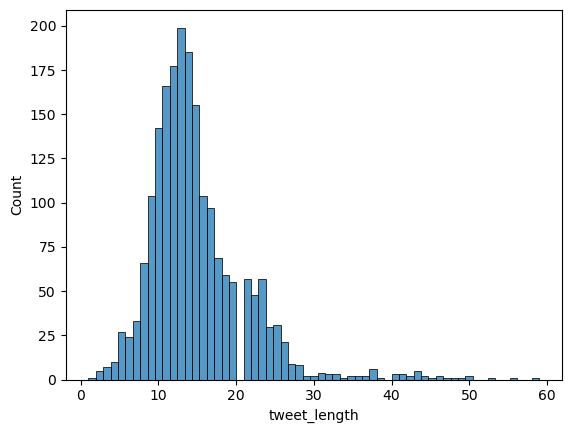


Frequency of hashtags and URLs:
Hashtags count:
 count    2000.000000
mean        1.133500
std         0.630775
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: hashtags_count, dtype: float64
URLs count:
 count    2000.00000
mean        0.99850
std         0.04999
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         2.00000
Name: urls_count, dtype: float64

Most common hashtags:
[('[]', 1623), (" 'M7UGsChoice'", 20), ("['top']", 9), ("['mar']", 7), (" 'ThankYouPoliceUg'", 6), ('nan', 5), ("['th'", 5), (" 'th']", 5), ("['vero'", 5), (" 'ver']", 5)]

Most common URLs:
[('[]', 658), ('nan', 4), ("['http://viid.me/qgnarc']", 2), ("['http://viid.me/qdHOdf']", 2), ("['http://ift.tt/2xaT33z']", 2), ("['http://ift.tt/2fNrg6s']", 2), ("['http://viid.me/qup616']", 2), ("['http://ift.tt/2hVOcRM']", 2), ("['http://viid.me/qwFXsv']", 2), ("['http://viid.me/qpVu4a']", 2)]


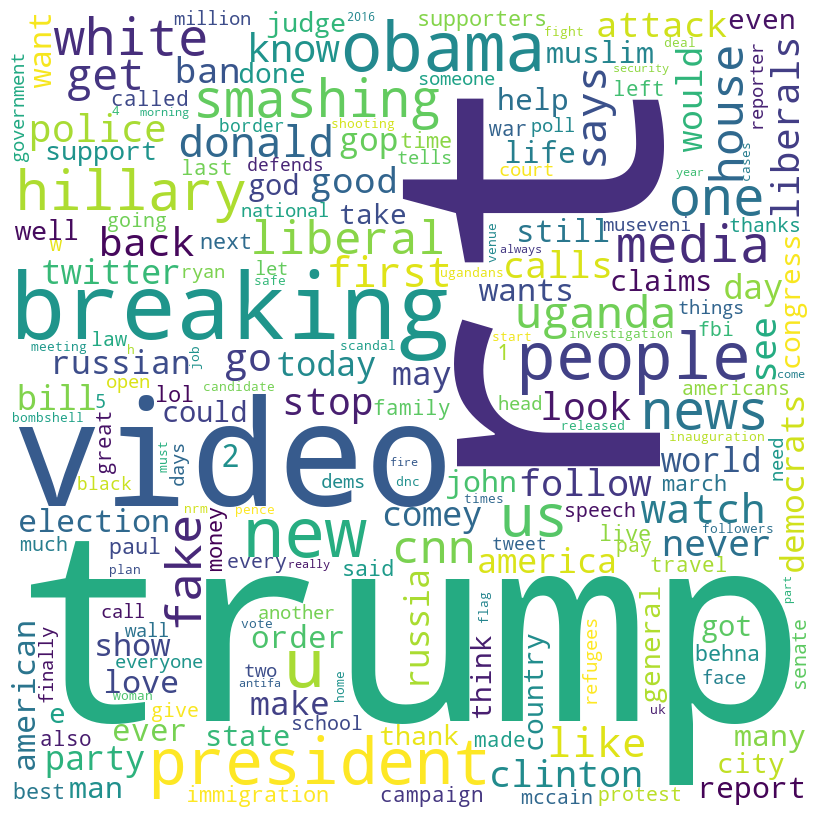

In [6]:
from nltk.tokenize import TweetTokenizer
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
data = eng_tweets_vicuna_rules_classification_only
# Preprocess tweet text by removing stopwords, tokenizing, and lowercasing words
def preprocess_tweet_text(text):
    tokens = TweetTokenizer().tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in stopwords.words("english")]

print("\nMost common words and phrases in tweet_text:")
all_words = [word for tweet in data["tweet_text"] for word in preprocess_tweet_text(tweet)]
word_freq = Counter(all_words)
print(word_freq.most_common(10))

print("\nDistribution of tweet lengths:")
data["tweet_length"] = data["tweet_text"].apply(lambda x: len(x.split()))
sns.histplot(data["tweet_length"])
plt.show()

print("\nFrequency of hashtags and URLs:")
data["hashtags_count"] = data["hashtags"].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
data["urls_count"] = data["urls"].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
print("Hashtags count:\n", data["hashtags_count"].describe())
print("URLs count:\n", data["urls_count"].describe())

print("\nMost common hashtags:")
hashtags = [hashtag for hashtags in data["hashtags"] for hashtag in str(hashtags).split(',')]
hashtag_freq = Counter(hashtags)
print(hashtag_freq.most_common(10))

print("\nMost common URLs:")
urls = [url for urls in data["urls"] for url in str(urls).split(',')]
url_freq = Counter(urls)
print(url_freq.most_common(10))

# Visualize most common words using WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords.words("english"), min_font_size=10).generate_from_frequencies(word_freq)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [20]:
from nltk.tokenize import TweetTokenizer
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    data = df.copy()
    # Preprocess tweet text by removing stopwords, tokenizing, and lowercasing words
    def preprocess_tweet_text(text):
        tokens = TweetTokenizer().tokenize(text.lower())
        return [word for word in tokens if word.isalnum() and word not in stopwords.words("english")]

    print("\nMost common words and phrases in tweet_text:")
    all_words = [word for tweet in data["tweet_text"] for word in preprocess_tweet_text(tweet)]
    word_freq = Counter(all_words)
    print(word_freq.most_common(10))

    print("\nDistribution of tweet lengths:")
    data["tweet_length"] = data["tweet_text"].apply(lambda x: len(x.split()))
    sns.histplot(data["tweet_length"])
    plt.show()

    print("\nFrequency of hashtags and URLs:")
    data["hashtags_count"] = data["hashtags"].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
    data["urls_count"] = data["urls"].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)
    print("Hashtags count:\n", data["hashtags_count"].describe())
    print("URLs count:\n", data["urls_count"].describe())

    print("\nMost common hashtags:")
    hashtags = [hashtag for hashtags in data["hashtags"] for hashtag in str(hashtags).split(',')]
    hashtag_freq = Counter(hashtags)
    print(hashtag_freq.most_common(10))

    print("\nMost common URLs:")
    urls = [url for urls in data["urls"] for url in str(urls).split(',')]
    url_freq = Counter(urls)
    print(url_freq.most_common(10))

    # Visualize most common words using WordCloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords.words("english"), min_font_size=10).generate_from_frequencies(word_freq)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

for df, name in zip(dataframes, df_names): 
    print(df.annotations)
    all_df = df[df["annotations"] != []]
    distinct_df = df[len(df["annotations"]) == 1]
    print("eda for all", name)
    eda(all_df)
    print("eda for distinct", name)
    eda(distinct_df)

0       []
1       []
2       []
3       []
4       []
        ..
1995    []
1996    []
1997    []
1998    []
1999    []
Name: annotations, Length: 2000, dtype: object


ValueError: ('Lengths must match to compare', (2000,), (0,))